In [7]:
# General imports
import os
import sys
import pandas as pd
import scipy
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from tqdm import tqdm
sys.path.append('../')
# Other imports

tqdm.pandas()
import yaml
import json

import xml.etree.ElementTree as ET

## YAML FILES CONFIG
yaml = yaml.load(open("config/config_files.yaml"), Loader=yaml.FullLoader)
base_dir = yaml['base_directory']
sys.exit('EXIT : Need to specify the base_directory in config file : "conf_files.yaml"') if base_dir == 'TO_CHANGE' else None
    

In [28]:
# General imports
import os
import sys
import pandas as pd
import scipy
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from tqdm import tqdm
sys.path.append('../')
# Other imports

tqdm.pandas()
import yaml
import json

# Figures imports
import matplotlib
from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=30, progress_bar=True)


## YAML FILES CONFIG
yaml = yaml.load(open("config/config_files.yaml"), Loader=yaml.FullLoader)
base_dir = yaml['base_directory']
sys.exit('EXIT : Need to specify the base_directory in config file : "conf_files.yaml"') if base_dir == 'TO_CHANGE' else None
    


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

pvalues_cutoff = json.load(open('config/config_files.json'))['pvalues_cutoff']
pvalues_cutoff = [[e, str(e)] for e in pvalues_cutoff]

import matplotlib.font_manager as font_manager

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18

INFO: Pandarallel will run on 30 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# Retrieve HS genes

In [8]:
genes = pd.read_parquet('/gstock/GeneIso/V2/Genes.parquet')

# Identify Orthologs in MM

In [264]:
tree = ET.parse('/gstock/GeneIso/data/External/ENSEMBL/mm_ortho.xml')
root = tree.getroot()
cols = [sub_child.attrib['name'] for child in root for sub_child in child  if sub_child.tag == 'Attribute']

# Retrieve MM orthologs from ENSEMBL BIOMART

mm_ortho = pd.read_csv('/gstock/GeneIso/data/External/ENSEMBL/mmusculus_orthologs.txt.gz', compression='gzip', sep='\t', names=cols)

In [ ]:
tmp['MM_Gene_Length'] = tmp['end_position'] - tmp['start_position']
tmp[['Miso_siso', 'GeneID', 'Gene name', 'Gene_length', 'mmusculus_homolog_associated_gene_name', 'mmusculus_homolog_ensembl_gene', 'start_position', 'end_position', 'MM_Gene_Length']]

## HS & MM Gene length

In [102]:
tmp[['Miso_siso', 'GeneID', 'mmusculus_homolog_ensembl_gene', 'Gene_length','MM_Gene_Length']].drop_duplicates().groupby('Miso_siso')[['Gene_length','MM_Gene_Length']].describe().round(0).astype(int)

Gene_length                                                    \
                count   mean     std  min    25%    50%    75%      max   
Miso_siso                                                                 
Miso             9990  80510  142588  704  14459  35440  87267  2473538   
Siso             3712  49699   87567  629   8663  21922  54335  1899593   

          MM_Gene_Length                                                    
                   count   mean     std  min    25%    50%    75%      max  
Miso_siso                                                                   
Miso                9990  61784  125374  311  10670  25388  62636  2960898  
Siso                3712  40447   79054  389   7586  17786  41753  2058378

# Count transcript / gene in MM

In [71]:
transcript_count_mm = tmp[['mmusculus_homolog_ensembl_gene', 'ensembl_transcript_id']].drop_duplicates().groupby(['mmusculus_homolog_ensembl_gene'])['ensembl_transcript_id'].count().rename('transcript_count_mm').reset_index()
transcript_count_mm.loc[transcript_count_mm['transcript_count_mm'] > 1, 'Miso_siso_mm'] = 'Miso'
transcript_count_mm.loc[transcript_count_mm['transcript_count_mm'] == 1, 'Miso_siso_mm'] = 'Siso'

transcript_count_mm

,mmusculus_homolog_ensembl_gene,transcript_count_mm,Miso_siso_mm
0,ENSMUSG00000000001,1,Siso
1,ENSMUSG00000000028,2,Miso
2,ENSMUSG00000000049,1,Siso
3,ENSMUSG00000000056,1,Siso
4,ENSMUSG00000000058,3,Miso
...,...,...,...
13223,ENSMUSG00000118665,2,Miso
13224,ENSMUSG00000118667,1,Siso
13225,ENSMUSG00000118668,1,Siso
13226,ENSMUSG00000118669,7,Miso


# MISOG / SISOG count 

In [76]:
tmp_merge = pd.merge(tmp[['GeneID', 'Miso_siso', 'mmusculus_homolog_ensembl_gene', 'transcript_count_x']], transcript_count_mm, on='mmusculus_homolog_ensembl_gene').drop_duplicates()
tmp_merge.groupby('Miso_siso')['Miso_siso_mm'].value_counts()

Miso_siso  Miso_siso_mm
Miso       Miso            6623
           Siso            3367
Siso       Siso            2143
           Miso            1569
Name: Miso_siso_mm, dtype: int64

In [12]:
tree = ET.parse('/gstock/GeneIso/data/External/ENSEMBL/mm_genes.xml')
root = tree.getroot()
# for child in root:
#     for sub_child in child:
#         print(sub_child.tag, sub_child.attrib)

cols = [sub_child.attrib['name'] for child in root for sub_child in child  if sub_child.tag == 'Attribute']
     
cols

['ensembl_gene_id',
 'ensembl_transcript_id',
 'ensembl_peptide_id',
 'description',
 'chromosome_name',
 'start_position',
 'end_position',
 'strand',
 'transcript_start',
 'transcript_end',
 'transcription_start_site',
 'transcript_length',
 'transcript_tsl',
 'transcript_gencode_basic',
 'transcript_appris',
 'external_gene_name',
 'external_gene_source',
 'external_transcript_name',
 'external_transcript_source_name',
 'transcript_count',
 'percentage_gene_gc_content',
 'gene_biotype',
 'transcript_biotype',
 'source',
 'transcript_source']

# Load MM genes + mRNA BIOMART file 

In [13]:
tree = ET.parse('/gstock/GeneIso/data/External/ENSEMBL/mm_genes.xml')
root = tree.getroot()
cols = [sub_child.attrib['name'] for child in root for sub_child in child  if sub_child.tag == 'Attribute']
        
mm_genes_mrna = pd.read_csv('/gstock/GeneIso/data/External/ENSEMBL/mmusculus_genes_mrnas.txt.gz', compression='gzip', sep='\t', names=cols)
mm_genes_mrna

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ensembl_gene_id,ensembl_transcript_id,ensembl_peptide_id,description,chromosome_name,start_position,end_position,strand,transcript_start,transcript_end,...,external_gene_name,external_gene_source,external_transcript_name,external_transcript_source_name,transcript_count,percentage_gene_gc_content,gene_biotype,transcript_biotype,source,transcript_source
0,ENSMUSG00000064341,ENSMUST00000082392,ENSMUSP00000080991,mitochondrially encoded NADH dehydrogenase 1 [...,MT,2751,3707,1,2751,3707,...,mt-Nd1,MGI Symbol,mt-Nd1-201,MGI transcript name,1,37.62,protein_coding,protein_coding,RefSeq,RefSeq
1,ENSMUSG00000064345,ENSMUST00000082396,ENSMUSP00000080992,mitochondrially encoded NADH dehydrogenase 2 [...,MT,3914,4951,1,3914,4951,...,mt-Nd2,MGI Symbol,mt-Nd2-201,MGI transcript name,1,35.74,protein_coding,protein_coding,RefSeq,RefSeq
2,ENSMUSG00000064351,ENSMUST00000082402,ENSMUSP00000080993,mitochondrially encoded cytochrome c oxidase I...,MT,5328,6872,1,5328,6872,...,mt-Co1,MGI Symbol,mt-Co1-201,MGI transcript name,1,39.87,protein_coding,protein_coding,RefSeq,RefSeq
3,ENSMUSG00000064354,ENSMUST00000082405,ENSMUSP00000080994,mitochondrially encoded cytochrome c oxidase I...,MT,7013,7696,1,7013,7696,...,mt-Co2,MGI Symbol,mt-Co2-201,MGI transcript name,1,38.60,protein_coding,protein_coding,RefSeq,RefSeq
4,ENSMUSG00000064356,ENSMUST00000082407,ENSMUSP00000080995,mitochondrially encoded ATP synthase 8 [Source...,MT,7766,7969,1,7766,7969,...,mt-Atp8,MGI Symbol,mt-Atp8-201,MGI transcript name,1,31.86,protein_coding,protein_coding,RefSeq,RefSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45426,ENSMUSG00000037761,ENSMUST00000045644,ENSMUSP00000046658,ARP5 actin-related protein 5 [Source:MGI Symbo...,2,158466808,158481131,1,158466808,158481131,...,Actr5,MGI Symbol,Actr5-201,MGI transcript name,5,49.82,protein_coding,protein_coding,ensembl_havana,ensembl_havana
45427,ENSMUSG00000037754,ENSMUST00000052927,ENSMUSP00000062615,"protein phosphatase 1, regulatory subunit 16B ...",2,158507318,158608254,1,158507318,158608254,...,Ppp1r16b,MGI Symbol,Ppp1r16b-202,MGI transcript name,5,49.34,protein_coding,protein_coding,ensembl_havana,ensembl_havana
45428,ENSMUSG00000037754,ENSMUST00000103116,ENSMUSP00000099405,"protein phosphatase 1, regulatory subunit 16B ...",2,158507318,158608254,1,158508653,158608254,...,Ppp1r16b,MGI Symbol,Ppp1r16b-203,MGI transcript name,5,49.34,protein_coding,protein_coding,ensembl_havana,ensembl
45429,ENSMUSG00000037754,ENSMUST00000045503,ENSMUSP00000039540,"protein phosphatase 1, regulatory subunit 16B ...",2,158507318,158608254,1,158509039,158608254,...,Ppp1r16b,MGI Symbol,Ppp1r16b-201,MGI transcript name,5,49.34,protein_coding,protein_coding,ensembl_havana,ensembl_havana


# Load MM exons file from ENSEMBL BIOMART

In [14]:
tree = ET.parse('/gstock/GeneIso/data/External/ENSEMBL/mm_exons.xml')
root = tree.getroot()
cols_exons = [sub_child.attrib['name']  for child in root for sub_child in child if sub_child.tag == 'Attribute']
# for child in root:
#     for sub_child in child:
#         print(sub_child.tag, sub_child.attrib)
        
mm_exons = pd.read_csv('/gstock/GeneIso/data/External/ENSEMBL/mmusculus_exons.txt.gz', compression='gzip', sep='\t', names=cols_exons)
mm_exons
# cols

,ensembl_gene_id,ensembl_transcript_id,external_gene_name,exon_chrom_start,exon_chrom_end,is_constitutive,rank,phase,end_phase,cdna_coding_start,cdna_coding_end,genomic_coding_start,genomic_coding_end,ensembl_exon_id,cds_start,cds_end
0,ENSMUSG00000064341,ENSMUST00000082392,mt-Nd1,2751,3707,1,1,0,0,1.0,957.0,2751.0,3707.0,ENSMUSE00000521519,1.0,957.0
1,ENSMUSG00000064345,ENSMUST00000082396,mt-Nd2,3914,4951,1,1,0,0,1.0,1038.0,3914.0,4951.0,ENSMUSE00000521523,1.0,1038.0
2,ENSMUSG00000064351,ENSMUST00000082402,mt-Co1,5328,6872,1,1,0,0,1.0,1545.0,5328.0,6872.0,ENSMUSE00000521529,1.0,1545.0
3,ENSMUSG00000064354,ENSMUST00000082405,mt-Co2,7013,7696,1,1,0,0,1.0,684.0,7013.0,7696.0,ENSMUSE00000521532,1.0,684.0
4,ENSMUSG00000064356,ENSMUST00000082407,mt-Atp8,7766,7969,1,1,0,0,1.0,204.0,7766.0,7969.0,ENSMUSE00000521534,1.0,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456646,ENSMUSG00000074625,ENSMUST00000099133,Arhgap40,158385125,158385328,0,11,0,0,1366.0,1569.0,158385125.0,158385328.0,ENSMUSE00001211012,1357.0,1560.0
456647,ENSMUSG00000074625,ENSMUST00000099133,Arhgap40,158388628,158388768,0,12,0,0,1570.0,1710.0,158388628.0,158388768.0,ENSMUSE00001226367,1561.0,1701.0
456648,ENSMUSG00000074625,ENSMUST00000099133,Arhgap40,158389539,158389714,0,13,0,2,1711.0,1886.0,158389539.0,158389714.0,ENSMUSE00001243585,1702.0,1877.0
456649,ENSMUSG00000074625,ENSMUST00000099133,Arhgap40,158391566,158391615,0,14,2,1,1887.0,1936.0,158391566.0,158391615.0,ENSMUSE00001251327,1878.0,1927.0


# Select closest MM ortholog for each HS gene

In [314]:
def select_ortho(df):
#     print(df[['mmusculus_homolog_associated_gene_name', 'ensembl_gene_id', 'mmusculus_homolog_ensembl_gene', 'mmusculus_homolog_orthology_type', 'mmusculus_homolog_chromosome',  'mmusculus_homolog_perc_id', 'mmusculus_homolog_perc_id_r1', 'mmusculus_homolog_goc_score', 'mmusculus_homolog_wga_coverage', 'mmusculus_homolog_orthology_confidence']])
    df = df.loc[df['mmusculus_homolog_orthology_confidence'] == 1]
    df = df.dropna(subset=['Gene name'])
    max_percent_id = df.mmusculus_homolog_perc_id.max()
    max_percent_id_r1 = df.mmusculus_homolog_perc_id_r1.max()
    max_goc_score = df.mmusculus_homolog_goc_score.max()
    max_wga_coverage = df.mmusculus_homolog_wga_coverage.max()
    df = df.loc[
        (df['mmusculus_homolog_perc_id'] == max_percent_id) &
        (df['mmusculus_homolog_perc_id_r1'] == max_percent_id_r1) &
        (df['mmusculus_homolog_goc_score'] == max_goc_score) &
        (df['mmusculus_homolog_wga_coverage'] == max_wga_coverage)
    ]
    df = df.drop_duplicates()
    if df.shape[0] > 1:
        ortho_genes = df.mmusculus_homolog_associated_gene_name.tolist()
        start_gene = df['Gene name'].values[0]
        target = [gene for gene in ortho_genes if gene.lower() == start_gene.lower()]
        if len(target) == 0:
            target = ortho_genes[0]
        else:
            target = target[0]
        df = df.loc[df['mmusculus_homolog_associated_gene_name'] == target].reset_index(drop=True)
        if df.shape[0] > 1:
            df = pd.DataFrame(df.loc[0]).T
            
#     print(df[['mmusculus_homolog_associated_gene_name', 'ensembl_gene_id', 'mmusculus_homolog_ensembl_gene', 'mmusculus_homolog_orthology_type', 'mmusculus_homolog_chromosome',  'mmusculus_homolog_perc_id', 'mmusculus_homolog_perc_id_r1', 'mmusculus_homolog_goc_score', 'mmusculus_homolog_wga_coverage', 'mmusculus_homolog_orthology_confidence']])
    return df
tmp_merge = pd.merge(
    pd.merge(
        genes, 
        mm_ortho[['mmusculus_homolog_associated_gene_name', 'ensembl_gene_id', 'mmusculus_homolog_ensembl_gene', 'mmusculus_homolog_orthology_type', 'mmusculus_homolog_chromosome',  'mmusculus_homolog_perc_id', 'mmusculus_homolog_perc_id_r1', 'mmusculus_homolog_goc_score', 'mmusculus_homolog_wga_coverage', 'mmusculus_homolog_orthology_confidence']]
        .drop_duplicates().rename({'ensembl_gene_id': 'GeneID'}, axis=1)
    ),
    mm_genes_mrna.drop(['transcript_count', 'external_gene_name'], axis=1)[['ensembl_gene_id', 'chromosome_name', 'start_position', 'end_position', 'source']],
    left_on='mmusculus_homolog_ensembl_gene',
    right_on='ensembl_gene_id'
)
# print(tmp_merge)
tmp_merge = tmp_merge.groupby('GeneID').progress_apply(select_ortho).reset_index(drop=True)
# print(tmp_merge)
tmp_merge


  5%|▌         | 659/12717 [00:06<01:59, 100.83it/s]

['ZC3H11A' 'ZC3H11A']
['Zc3h11a', 'Zc3h11a']
Zc3h11a


 26%|██▌       | 3260/12717 [00:32<01:28, 107.27it/s]

['NNT' 'NNT']
['Nnt', 'Nnt']
Nnt


 38%|███▊      | 4785/12717 [00:46<01:16, 103.31it/s]

['GDF1' 'GDF1']
['Cers1', 'Gdf1']
Gdf1


 46%|████▌     | 5848/12717 [00:57<01:03, 107.55it/s]

['COX17' 'COX17']
['Cox17', 'Gm21987']
Cox17


 56%|█████▌    | 7121/12717 [01:09<00:52, 105.88it/s]

['DST' 'DST']
['Dst', 'Dst']
Dst


 71%|███████▏  | 9087/12717 [01:28<00:35, 102.63it/s]

['SEPTIN2' 'SEPTIN2']
['Septin2', 'Septin2']
Septin2


 86%|████████▋ | 10999/12717 [01:46<00:16, 106.41it/s]

['EVI2B' 'EVI2B']
['Evi2b', 'Evi2']
Evi2b


 95%|█████████▍| 12081/12717 [01:57<00:05, 108.39it/s]

['ADAT3' 'ADAT3']
['Adat3', 'Gm49322']
Adat3


 99%|█████████▉| 12632/12717 [02:02<00:00, 118.90it/s]

['TAF9' 'TAF9']
['Taf9', 'Ak6']
Taf9


100%|█████████▉| 12698/12717 [02:02<00:00, 123.43it/s]

['PAGR1' 'PAGR1']
['Gm42742', 'Pagr1a']
Gm42742


100%|██████████| 12717/12717 [02:40<00:00, 79.02it/s] 


,GeneID,transcript_count,Miso_siso,Gene name,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Gene_length,mmusculus_homolog_associated_gene_name,mmusculus_homolog_ensembl_gene,...,mmusculus_homolog_perc_id,mmusculus_homolog_perc_id_r1,mmusculus_homolog_goc_score,mmusculus_homolog_wga_coverage,mmusculus_homolog_orthology_confidence,ensembl_gene_id,chromosome_name,start_position,end_position,source
0,ENSG00000000003,3,Miso,TSPAN6,X,100627108,100639991,12883,Tspan6,ENSMUSG00000067377,...,93.0612,93.0612,100.0,100.0,1.0,ENSMUSG00000067377,X,132791817,132799178,ensembl_havana
1,ENSG00000000005,1,Siso,TNMD,X,100584936,100599885,14949,Tnmd,ENSMUSG00000031250,...,96.2145,96.2145,100.0,100.0,1.0,ENSMUSG00000031250,X,132751729,132766326,ensembl_havana
2,ENSG00000000419,3,Miso,DPM1,20,50934867,50959140,24273,Dpm1,ENSMUSG00000078919,...,91.1538,91.1538,100.0,100.0,1.0,ENSMUSG00000078919,2,168050968,168072511,ensembl_havana
3,ENSG00000000457,3,Miso,SCYL3,1,169849631,169894267,44636,Scyl3,ENSMUSG00000026584,...,82.8488,77.551,100.0,100.0,1.0,ENSMUSG00000026584,1,163756669,163782695,ensembl_havana
4,ENSG00000000460,4,Miso,C1orf112,1,169662007,169854080,192073,BC055324,ENSMUSG00000041406,...,72.0985,66.343,0.0,99.21,1.0,ENSMUSG00000041406,1,163773562,163822365,ensembl_havana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12198,ENSG00000284770,3,Miso,TBCE,1,235367360,235452443,85083,Tbce,ENSMUSG00000039233,...,74.1936,74.6183,100.0,100.0,1.0,ENSMUSG00000039233,13,14172534,14214223,ensembl_havana
12199,ENSG00000285292,1,Siso,ABCF2-H2BE1,7,151207837,151227166,19329,Abcf2,ENSMUSG00000028953,...,97.4763,98.4076,100.0,99.41,1.0,ENSMUSG00000028953,5,24770343,24782465,ensembl_havana
12200,ENSG00000285437,3,Miso,POLR2J3,7,102562133,102572583,10450,Polr2j,ENSMUSG00000039771,...,91.3043,89.7436,50.0,91.14,1.0,ENSMUSG00000039771,5,136145485,136151801,ensembl_havana
12201,ENSG00000285508,1,Siso,MKKS,20,10413520,10431922,18402,NaN,ENSMUSG00000115423,...,72.0,72.0,100.0,100.0,1.0,ENSMUSG00000115423,2,136723191,136733309,havana


# Merge previous dataframe with mRNA dataframe

In [406]:
mm_genes_mrna_final = pd.merge(
    tmp_merge[['Miso_siso', 'GeneID', 'Gene name', 'mmusculus_homolog_associated_gene_name', 'mmusculus_homolog_ensembl_gene', 'ensembl_gene_id']],
    mm_genes_mrna,
    on=['ensembl_gene_id']
)

mm_genes_mrna_final = mm_genes_mrna_final.drop_duplicates(subset=['Miso_siso', 'ensembl_gene_id', 'ensembl_transcript_id']).dropna(subset=['mmusculus_homolog_associated_gene_name'])

mm_genes_mrna_final['chromosome_name'] = mm_genes_mrna_final['chromosome_name'].astype(str)

mm_genes_mrna_final.to_parquet('/gstock/GeneIso/V2/Genes_MM.parquet')

mm_genes_mrna_final

,Miso_siso,GeneID,Gene name,mmusculus_homolog_associated_gene_name,mmusculus_homolog_ensembl_gene,ensembl_gene_id,ensembl_transcript_id,ensembl_peptide_id,description,chromosome_name,...,external_gene_name,external_gene_source,external_transcript_name,external_transcript_source_name,transcript_count,percentage_gene_gc_content,gene_biotype,transcript_biotype,source,transcript_source
0,Miso,ENSG00000000003,TSPAN6,Tspan6,ENSMUSG00000067377,ENSMUSG00000067377,ENSMUST00000087557,ENSMUSP00000084838,tetraspanin 6 [Source:MGI Symbol;Acc:MGI:1926264],X,...,Tspan6,MGI Symbol,Tspan6-201,MGI transcript name,4,40.49,protein_coding,protein_coding,ensembl_havana,ensembl_havana
1,Siso,ENSG00000000005,TNMD,Tnmd,ENSMUSG00000031250,ENSMUSG00000031250,ENSMUST00000033602,ENSMUSP00000033602,tenomodulin [Source:MGI Symbol;Acc:MGI:1929885],X,...,Tnmd,MGI Symbol,Tnmd-201,MGI transcript name,1,41.23,protein_coding,protein_coding,ensembl_havana,ensembl_havana
2,Miso,ENSG00000000419,DPM1,Dpm1,ENSMUSG00000078919,ENSMUSG00000078919,ENSMUST00000154111,ENSMUSP00000118776,dolichol-phosphate (beta-D) mannosyltransferas...,2,...,Dpm1,MGI Symbol,Dpm1-209,MGI transcript name,10,44.93,protein_coding,protein_coding,ensembl_havana,ensembl_havana
3,Miso,ENSG00000000419,DPM1,Dpm1,ENSMUSG00000078919,ENSMUSG00000078919,ENSMUST00000109193,ENSMUSP00000104816,dolichol-phosphate (beta-D) mannosyltransferas...,2,...,Dpm1,MGI Symbol,Dpm1-202,MGI transcript name,10,44.93,protein_coding,protein_coding,ensembl_havana,havana
4,Miso,ENSG00000000457,SCYL3,Scyl3,ENSMUSG00000026584,ENSMUSG00000026584,ENSMUST00000161908,ENSMUSP00000125735,SCY1-like 3 (S. cerevisiae) [Source:MGI Symbol...,1,...,Scyl3,MGI Symbol,Scyl3-203,MGI transcript name,7,43.74,protein_coding,protein_coding,ensembl_havana,havana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27997,Miso,ENSG00000284308,C2orf81,1700003E16Rik,ENSMUSG00000030030,ENSMUSG00000030030,ENSMUST00000203203,ENSMUSP00000145406,RIKEN cDNA 1700003E16 gene [Source:MGI Symbol;...,6,...,1700003E16Rik,MGI Symbol,1700003E16Rik-202,MGI transcript name,2,49.88,protein_coding,protein_coding,ensembl_havana,havana
27998,Siso,ENSG00000284753,EEF1AKMT4,Eef1akmt4,ENSMUSG00000115219,ENSMUSG00000115219,ENSMUST00000115522,ENSMUSP00000111184,EEF1A lysine methyltransferase 4 [Source:MGI S...,16,...,Eef1akmt4,MGI Symbol,Eef1akmt4-201,MGI transcript name,2,45.36,protein_coding,protein_coding,ensembl_havana,ensembl_havana
27999,Siso,ENSG00000284753,EEF1AKMT4,Eef1akmt4,ENSMUSG00000115219,ENSMUSG00000115219,ENSMUST00000119224,ENSMUSP00000113772,EEF1A lysine methyltransferase 4 [Source:MGI S...,16,...,Eef1akmt4,MGI Symbol,Eef1akmt4-202,MGI transcript name,2,45.36,protein_coding,protein_coding,ensembl_havana,havana
28000,Miso,ENSG00000284770,TBCE,Tbce,ENSMUSG00000039233,ENSMUSG00000039233,ENSMUST00000039894,ENSMUSP00000047880,tubulin-specific chaperone E [Source:MGI Symbo...,13,...,Tbce,MGI Symbol,Tbce-201,MGI transcript name,13,43.03,protein_coding,protein_coding,ensembl_havana,ensembl_havana


# Merge with exons

In [407]:
exon_mm = pd.merge(
    mm_genes_mrna_final,
    mm_exons,
    on=['ensembl_gene_id', 'ensembl_transcript_id'],
)    
exon_mm


,Miso_siso,GeneID,Gene name,mmusculus_homolog_associated_gene_name,mmusculus_homolog_ensembl_gene,ensembl_gene_id,ensembl_transcript_id,ensembl_peptide_id,description,chromosome_name,...,rank,phase,end_phase,cdna_coding_start,cdna_coding_end,genomic_coding_start,genomic_coding_end,ensembl_exon_id,cds_start,cds_end
0,Miso,ENSG00000000003,TSPAN6,Tspan6,ENSMUSG00000067377,ENSMUSG00000067377,ENSMUST00000087557,ENSMUSP00000084838,tetraspanin 6 [Source:MGI Symbol;Acc:MGI:1926264],X,...,1,-1,0,136.0,222.0,132798957.0,132799043.0,ENSMUSE00000546501,1.0,87.0
1,Miso,ENSG00000000003,TSPAN6,Tspan6,ENSMUSG00000067377,ENSMUSG00000067377,ENSMUST00000087557,ENSMUSP00000084838,tetraspanin 6 [Source:MGI Symbol;Acc:MGI:1926264],X,...,2,0,0,223.0,411.0,132797873.0,132798061.0,ENSMUSE00001275102,88.0,276.0
2,Miso,ENSG00000000003,TSPAN6,Tspan6,ENSMUSG00000067377,ENSMUSG00000067377,ENSMUST00000087557,ENSMUSP00000084838,tetraspanin 6 [Source:MGI Symbol;Acc:MGI:1926264],X,...,3,0,0,412.0,486.0,132797432.0,132797506.0,ENSMUSE00000546495,277.0,351.0
3,Miso,ENSG00000000003,TSPAN6,Tspan6,ENSMUSG00000067377,ENSMUSG00000067377,ENSMUST00000087557,ENSMUSP00000084838,tetraspanin 6 [Source:MGI Symbol;Acc:MGI:1926264],X,...,4,0,0,487.0,585.0,132796184.0,132796282.0,ENSMUSE00000546493,352.0,450.0
4,Miso,ENSG00000000003,TSPAN6,Tspan6,ENSMUSG00000067377,ENSMUSG00000067377,ENSMUST00000087557,ENSMUSP00000084838,tetraspanin 6 [Source:MGI Symbol;Acc:MGI:1926264],X,...,5,0,0,586.0,720.0,132795677.0,132795811.0,ENSMUSE00000546491,451.0,585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331358,Miso,ENSG00000284770,TBCE,Tbce,ENSMUSG00000039233,ENSMUSG00000039233,ENSMUST00000039894,ENSMUSP00000047880,tubulin-specific chaperone E [Source:MGI Symbo...,13,...,15,1,1,1463.0,1522.0,14174643.0,14174702.0,ENSMUSE00001264515,1331.0,1390.0
331359,Miso,ENSG00000284770,TBCE,Tbce,ENSMUSG00000039233,ENSMUSG00000039233,ENSMUST00000039894,ENSMUSP00000047880,tubulin-specific chaperone E [Source:MGI Symbo...,13,...,16,1,0,1523.0,1614.0,14172948.0,14173039.0,ENSMUSE00001252143,1391.0,1482.0
331360,Miso,ENSG00000284770,TBCE,Tbce,ENSMUSG00000039233,ENSMUSG00000039233,ENSMUST00000039894,ENSMUSP00000047880,tubulin-specific chaperone E [Source:MGI Symbo...,13,...,17,0,-1,1615.0,1707.0,14172674.0,14172766.0,ENSMUSE00000861337,1483.0,1575.0
331361,Miso,ENSG00000286140,DERPC,Derpc,ENSMUSG00000117748,ENSMUSG00000117748,ENSMUST00000169312,ENSMUSP00000129823,DERPC proline and glycine rich nuclear protein...,8,...,1,-1,-1,NaN,NaN,NaN,NaN,ENSMUSE00001458239,NaN,NaN


# Retrieve Ordinal & length for MM exons

In [408]:

def exon_ord(df, ortho_specie):
    if df.Strand.values[0] == 1:
        df = df.sort_values(by=['Exon region start (bp)', 'Exon region end (bp)'])

    elif df.Strand.values[0] == -1:
        df = df.sort_values(by=['Exon region start (bp)', 'Exon region end (bp)'], ascending=False)
    
    df['Ordinal_nb'] = list(range(1,df.shape[0]+1))
    df['Length'] = df['Exon region end (bp)'] - df['Exon region start (bp)']
    df['Ordinal_nb_inverted'] = np.array(list(range(1,df.shape[0] + 1))[::-1]) * -1
    df['Ortho_specie'] = ortho_specie
    
    return df[['Ortho_specie', 'Miso_siso', 'GeneID', 'Ortho_GeneID', 'Ortho_transcript_id', 'Strand', 'Chromosome/scaffold name', 'Exon region start (bp)', 'Exon region end (bp)', 'Ordinal_nb', 'Ordinal_nb_inverted', 'Length']]
    

exon_tmp_dev = exon_mm[['Miso_siso', 'GeneID', 'ensembl_gene_id', 'ensembl_transcript_id', 'strand', 'chromosome_name', 'exon_chrom_start', 'exon_chrom_end']]

exon_tmp_dev = exon_tmp_dev.drop_duplicates(subset=['Miso_siso', 'ensembl_gene_id', 'ensembl_transcript_id', 'strand', 'chromosome_name', 'exon_chrom_start', 'exon_chrom_end'])



exon_tmp_dev = exon_tmp_dev.rename(
    {
        'strand' : 'Strand',
        'chromosome_name' : 'Chromosome/scaffold name',
        'exon_chrom_start' : 'Exon region start (bp)',
        'exon_chrom_end' : 'Exon region end (bp)',
        'ensembl_gene_id' : 'Ortho_GeneID',
        'ensembl_transcript_id' : 'Ortho_transcript_id'
        
    }, axis=1
)
exon_tmp_dev = exon_tmp_dev.sort_values(by=['Chromosome/scaffold name', 'Exon region start (bp)', 'Exon region end (bp)', 'GeneID', 'Ortho_GeneID', 'Ortho_transcript_id'])

# exon_tmp_dev = exon_tmp_dev.loc[exon_tmp_dev['Ortho_GeneID'].isin(exon_tmp_dev['Ortho_GeneID'].unique().tolist()[:100])]

exon_tmp_dev = exon_tmp_dev.groupby(['Miso_siso', 'Ortho_GeneID', 'Ortho_transcript_id']).progress_apply(lambda r: exon_ord(r, 'Mus_Musculus')).reset_index(drop=True)


exon_tmp_dev['Chromosome/scaffold name'] = exon_tmp_dev['Chromosome/scaffold name'].astype(str)

# exon_tmp_dev.to_sql('Exons', engine, if_exists='replace')

exon_tmp_dev.to_parquet('/gstock/GeneIso/V2/Exons_MM.parquet')

exon_tmp_dev

100%|██████████| 27903/27903 [05:14<00:00, 88.64it/s] 


,Ortho_specie,Miso_siso,GeneID,Ortho_GeneID,Ortho_transcript_id,Strand,Chromosome/scaffold name,Exon region start (bp),Exon region end (bp),Ordinal_nb,Ordinal_nb_inverted,Length
0,Mus_Musculus,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630554,18630722,1,-20,168
1,Mus_Musculus,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630265,18630459,2,-19,194
2,Mus_Musculus,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630055,18630114,3,-18,59
3,Mus_Musculus,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18629139,18629231,4,-17,92
4,Mus_Musculus,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18627482,18627619,5,-16,137
...,...,...,...,...,...,...,...,...,...,...,...,...
331358,Mus_Musculus,Siso,ENSG00000187961,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156316004,156316171,8,-5,167
331359,Mus_Musculus,Siso,ENSG00000187961,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156315542,156315630,9,-4,88
331360,Mus_Musculus,Siso,ENSG00000187961,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156315358,156315431,10,-3,73
331361,Mus_Musculus,Siso,ENSG00000187961,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156314962,156315143,11,-2,181


# Retrieve Ordinal & length for MM CDS

In [409]:
def retrieve_cds_coord(df, ortho_specie):
    if df.Strand.values[0] == 1:
        df = df.sort_values(by=['Exon region start (bp)', 'Exon region end (bp)'])

        df_cds = df.dropna(subset=['CDS start', 'CDS end'])
        df_cds['Ordinal_nb'] = list(range(1,df_cds.shape[0]+1))
        df_cds['Ordinal_nb_inverted'] = np.array(list(range(1,df_cds.shape[0] + 1))[::-1]) * -1


    elif df.Strand.values[0] == -1:
        df = df.sort_values(by=['Exon region start (bp)', 'Exon region end (bp)'], ascending=False)

        df_cds = df.dropna(subset=['CDS start', 'CDS end'])
        df_cds['Ordinal_nb'] = list(range(1,df_cds.shape[0]+1))
        df_cds['Ordinal_nb_inverted'] = np.array(list(range(1,df_cds.shape[0] + 1))[::-1]) * -1


    df_cds['Length'] = df_cds['CDS end'] - df_cds['CDS start']
    df_cds['Ortho_specie'] = ortho_specie

    return df_cds



exon_tmp_dev = exon_mm[['Miso_siso', 'GeneID', 'ensembl_gene_id', 'ensembl_transcript_id', 'strand', 'chromosome_name', 'exon_chrom_start', 'exon_chrom_end', 'genomic_coding_start', 'genomic_coding_end']]

exon_tmp_dev = exon_tmp_dev.drop_duplicates(subset=['Miso_siso', 'ensembl_gene_id', 'ensembl_transcript_id', 'strand', 'chromosome_name', 'exon_chrom_start', 'exon_chrom_end'])

exon_tmp_dev = exon_tmp_dev.rename(
    {
        'strand' : 'Strand',
        'chromosome_name' : 'Chromosome/scaffold name',
        'exon_chrom_start' : 'Exon region start (bp)',
        'exon_chrom_end' : 'Exon region end (bp)',
        'genomic_coding_start' : 'CDS start',
        'genomic_coding_end' : 'CDS end',
        'ensembl_gene_id' : 'Ortho_GeneID',
        'ensembl_transcript_id' : 'Ortho_transcript_id'
        
    }, axis=1
)
exon_tmp_dev = exon_tmp_dev.sort_values(by=['Chromosome/scaffold name', 'Exon region start (bp)', 'Exon region end (bp)', 'GeneID', 'Ortho_GeneID', 'Ortho_transcript_id'])



# exon_tmp_dev = exon_tmp_dev.loc[exon_tmp_dev['GeneID'].isin(exon_tmp_dev['GeneID'].unique().tolist()[:100])]

cds = exon_tmp_dev.groupby(['Miso_siso', 'Ortho_GeneID', 'Ortho_transcript_id']).progress_apply(lambda r: retrieve_cds_coord(r, "Mus Musculus")).reset_index(drop=True)
cds['Chromosome/scaffold name'] = cds['Chromosome/scaffold name'].astype(str)

# cds.to_sql('CDS', engine, if_exists='replace')
cds.to_parquet('/gstock/GeneIso/V2/CDS_MM.parquet')

cds


100%|██████████| 27903/27903 [06:01<00:00, 77.18it/s] 


,Miso_siso,GeneID,Ortho_GeneID,Ortho_transcript_id,Strand,Chromosome/scaffold name,Exon region start (bp),Exon region end (bp),CDS start,CDS end,Ordinal_nb,Ordinal_nb_inverted,Length,Ortho_specie
0,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630265,18630459,18630265.0,18630315.0,1,-18,50.0,Mus Musculus
1,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630055,18630114,18630055.0,18630114.0,2,-17,59.0,Mus Musculus
2,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18629139,18629231,18629139.0,18629231.0,3,-16,92.0,Mus Musculus
3,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18627482,18627619,18627482.0,18627619.0,4,-15,137.0,Mus Musculus
4,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18626030,18626173,18626030.0,18626173.0,5,-14,143.0,Mus Musculus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312866,Siso,ENSG00000187961,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156316004,156316171,156316004.0,156316171.0,8,-5,167.0,Mus Musculus
312867,Siso,ENSG00000187961,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156315542,156315630,156315542.0,156315630.0,9,-4,88.0,Mus Musculus
312868,Siso,ENSG00000187961,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156315358,156315431,156315358.0,156315431.0,10,-3,73.0,Mus Musculus
312869,Siso,ENSG00000187961,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156314962,156315143,156314962.0,156315143.0,11,-2,181.0,Mus Musculus


# Define & Retrieve Ordinal & length for UTR

In [410]:
def retrieve_utr_ortho(df, ortho_specie):

    df = df.sort_values(by=['rank'])
    df['rank_inverted'] = np.array(list(range(1,df.shape[0] + 1))[::-1]) * -1
    cds_count = df.loc[df['genomic_coding_start'].isna() == False].shape[0]

    
    if df.strand.values[0] == 1:
        five_utr = df.loc[(df['exon_chrom_start'] != df['genomic_coding_start']) & (df['rank_inverted'] <= cds_count * -1)].reset_index(drop=True)
        five_utr.loc[five_utr['genomic_coding_end'].isna() == True, 'UTR_start'] = five_utr.loc[five_utr['genomic_coding_end'].isna() == True, 'exon_chrom_start']
        five_utr.loc[five_utr['genomic_coding_end'].isna() == True, 'UTR_end'] = five_utr.loc[five_utr['genomic_coding_end'].isna() == True, 'exon_chrom_end']
        five_utr.loc[five_utr['genomic_coding_end'].isna() == False, 'UTR_start'] = five_utr.loc[five_utr['genomic_coding_end'].isna() == False, 'exon_chrom_start']
        five_utr.loc[five_utr['genomic_coding_end'].isna() == False, 'UTR_end'] = five_utr.loc[five_utr['genomic_coding_end'].isna() == False, 'genomic_coding_start'] - 1
        five_utr['UTR'] = "5_prime"

        three_utr = df.loc[(df['exon_chrom_end'] != df['genomic_coding_end']) & (df['rank'] >= cds_count)].reset_index(drop=True)
        three_utr.loc[three_utr['genomic_coding_end'].isna() == True, 'UTR_start'] = three_utr.loc[three_utr['genomic_coding_end'].isna() == True, 'exon_chrom_start']
        three_utr.loc[three_utr['genomic_coding_end'].isna() == True, 'UTR_end'] = three_utr.loc[three_utr['genomic_coding_end'].isna() == True, 'exon_chrom_end']
        three_utr.loc[three_utr['genomic_coding_end'].isna() == False, 'UTR_start'] = three_utr.loc[three_utr['genomic_coding_end'].isna() == False, 'genomic_coding_end'] + 1
        three_utr.loc[three_utr['genomic_coding_end'].isna() == False, 'UTR_end'] = three_utr.loc[three_utr['genomic_coding_end'].isna() == False, 'exon_chrom_end']
        three_utr['UTR'] = "3_prime"

    if df.strand.values[0] == -1:
        five_utr = df.loc[(df['exon_chrom_start'] != df['genomic_coding_start']) & (df['rank'] >= cds_count)].reset_index(drop=True)
        five_utr.loc[five_utr['genomic_coding_end'].isna() == True, 'UTR_start'] = five_utr.loc[five_utr['genomic_coding_end'].isna() == True, 'exon_chrom_start']
        five_utr.loc[five_utr['genomic_coding_end'].isna() == True, 'UTR_end'] = five_utr.loc[five_utr['genomic_coding_end'].isna() == True, 'exon_chrom_end']
        five_utr.loc[five_utr['genomic_coding_end'].isna() == False, 'UTR_start'] = five_utr.loc[five_utr['genomic_coding_end'].isna() == False, 'exon_chrom_start']
        five_utr.loc[five_utr['genomic_coding_end'].isna() == False, 'UTR_end'] = five_utr.loc[five_utr['genomic_coding_end'].isna() == False, 'genomic_coding_start'] - 1
        five_utr['UTR'] = "3_prime"

        three_utr = df.loc[(df['exon_chrom_end'] != df['genomic_coding_end']) & (df['rank_inverted'] <= cds_count * -1)].reset_index(drop=True)
        three_utr.loc[three_utr['genomic_coding_end'].isna() == True, 'UTR_start'] = three_utr.loc[three_utr['genomic_coding_end'].isna() == True, 'exon_chrom_start']
        three_utr.loc[three_utr['genomic_coding_end'].isna() == True, 'UTR_end'] = three_utr.loc[three_utr['genomic_coding_end'].isna() == True, 'exon_chrom_end']
        three_utr.loc[three_utr['genomic_coding_end'].isna() == False, 'UTR_start'] = three_utr.loc[three_utr['genomic_coding_end'].isna() == False, 'genomic_coding_end'] + 1
        three_utr.loc[three_utr['genomic_coding_end'].isna() == False, 'UTR_end'] = three_utr.loc[three_utr['genomic_coding_end'].isna() == False, 'exon_chrom_end']
        three_utr['UTR'] = "5_prime"        
        

    final_utr = pd.concat([five_utr, three_utr])
    final_utr['Length'] = final_utr['UTR_end'] - final_utr['UTR_start']
    final_utr['Ortho_specie'] = ortho_specie

    return final_utr



# exon_tmp_dev = exon_mm.loc[exon_mm['GeneID'].isin(exon_mm['GeneID'].unique().tolist()[:100])]


utr = exon_mm[['Miso_siso', 'GeneID', 'ensembl_gene_id', 'ensembl_transcript_id', 'strand', 'chromosome_name', 'exon_chrom_start', 'exon_chrom_end', 'genomic_coding_start', 'genomic_coding_end', 'cds_start', 'cds_end', 'rank']]

utr = utr.drop_duplicates(subset=['Miso_siso', 'ensembl_gene_id', 'ensembl_transcript_id', 'strand', 'chromosome_name', 'exon_chrom_start', 'exon_chrom_end'])

utr = utr.groupby(['Miso_siso', 'ensembl_gene_id', 'ensembl_transcript_id']).progress_apply(lambda r: retrieve_utr_ortho(r, "Mus Musculus")).reset_index(drop=True)
five_UTR = utr.loc[utr['UTR'] == "5_prime"].rename({'rank' : 'Ordinal_nb', 'rank_inverted' : 'Ordinal_nb_inverted'}, axis=1).reset_index(drop=True)
three_UTR = utr.loc[utr['UTR'] == "3_prime"].rename({'rank' : 'Ordinal_nb', 'rank_inverted' : 'Ordinal_nb_inverted'}, axis=1).reset_index(drop=True)

five_UTR = five_UTR.rename(
    {
        'strand' : 'Strand',
        'chromosome_name' : 'Chromosome/scaffold name',
        'exon_chrom_start' : 'Exon region start (bp)',
        'exon_chrom_end' : 'Exon region end (bp)',
        'genomic_coding_start' : 'CDS start',
        'genomic_coding_end' : 'CDS end',
        'ensembl_gene_id' : 'Ortho_GeneID',
        'ensembl_transcript_id' : 'Ortho_transcript_id'
        
    }, axis=1
)

three_UTR = three_UTR.rename(
    {
        'strand' : 'Strand',
        'chromosome_name' : 'Chromosome/scaffold name',
        'exon_chrom_start' : 'Exon region start (bp)',
        'exon_chrom_end' : 'Exon region end (bp)',
        'genomic_coding_start' : 'CDS start',
        'genomic_coding_end' : 'CDS end',
        'ensembl_gene_id' : 'Ortho_GeneID',
        'ensembl_transcript_id' : 'Ortho_transcript_id'
        
    }, axis=1
)

five_UTR['Chromosome/scaffold name'] = five_UTR['Chromosome/scaffold name'].astype(str)
three_UTR['Chromosome/scaffold name'] = three_UTR['Chromosome/scaffold name'].astype(str)

five_UTR.to_parquet('/gstock/GeneIso/V2/5_UTR_MM.parquet')
three_UTR.to_parquet('/gstock/GeneIso/V2/3_UTR_MM.parquet')




five_UTR

100%|██████████| 27903/27903 [14:12<00:00, 32.71it/s]


,Miso_siso,GeneID,Ortho_GeneID,Ortho_transcript_id,Strand,Chromosome/scaffold name,Exon region start (bp),Exon region end (bp),CDS start,CDS end,cds_start,cds_end,Ordinal_nb,Ordinal_nb_inverted,UTR_start,UTR_end,UTR,Length,Ortho_specie
0,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630554,18630722,NaN,NaN,NaN,NaN,1,-20,18630554.0,18630722.0,5_prime,168.0,Mus Musculus
1,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630265,18630459,18630265.0,18630315.0,1.0,51.0,2,-19,18630316.0,18630459.0,5_prime,143.0,Mus Musculus
2,Miso,ENSG00000093009,ENSMUSG00000000028,ENSMUST00000096990,-1,16,18630265,18630376,18630265.0,18630315.0,1.0,51.0,1,-18,18630316.0,18630376.0,5_prime,60.0,Mus Musculus
3,Miso,ENSG00000141562,ENSMUSG00000000056,ENSMUST00000103015,1,11,121128079,121128177,121128151.0,121128177.0,1.0,27.0,1,-11,121128079.0,121128150.0,5_prime,71.0,Mus Musculus
4,Miso,ENSG00000105971,ENSMUSG00000000058,ENSMUST00000000058,1,6,17281184,17281509,17281360.0,17281509.0,1.0,150.0,1,-3,17281184.0,17281359.0,5_prime,175.0,Mus Musculus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43375,Siso,ENSG00000284753,ENSMUSG00000115219,ENSMUST00000119224,1,16,20430351,20430570,20430375.0,20430570.0,1.0,196.0,1,-2,20430351.0,20430374.0,5_prime,23.0,Mus Musculus
43376,Siso,ENSG00000253251,ENSMUSG00000118537,ENSMUST00000133280,-1,13,104314622,104314947,NaN,NaN,NaN,NaN,1,-2,104314622.0,104314947.0,5_prime,325.0,Mus Musculus
43377,Siso,ENSG00000253251,ENSMUSG00000118537,ENSMUST00000133280,-1,13,104310230,104311512,104310642.0,104311409.0,1.0,768.0,2,-1,104311410.0,104311512.0,5_prime,102.0,Mus Musculus
43378,Siso,ENSG00000171763,ENSMUSG00000118663,ENSMUST00000239506,1,2,122461120,122462240,122461167.0,122462240.0,1.0,1074.0,1,-8,122461120.0,122461166.0,5_prime,46.0,Mus Musculus


# Define & Retrieve Ordinal & length for MM introns

In [411]:
def exon_ord(df):

    
    df['Exon_nb'] = list(range(1,df.shape[0]+1))

    return df
    

# Fct to compute intron boundaries
def get_introns(df, ortho_specie):
    
#     if df.Strand.values[0] == 1:
    df = df.sort_values(by=['Exon region start (bp)', 'Exon region end (bp)'])
    df['ranges'] = df['Exon region start (bp)'].astype(str) + '-' + df['Exon region end (bp)'].astype(str)
    
    l = list()
    exons = df['ranges'].values.tolist()
    for j, e in enumerate(exons):
        # Exon 1
        if j == 0:
            l.append(int(e.split("-")[1]) + 1)
            
        # Exon 2 <-> Exon -2
        elif j > 0 and j < len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
            l.append(int(e.split("-")[1]) + 1)
            
        # Exon -1
        elif j == len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)

    # Final list        
    l = ["{}-{}".format(e, l[j + 1]) for j, e in enumerate(l) if j < len(l) - 1 if j % 2 == 0]
    df['Introns'] = l + [np.nan]

    
    if df.Strand.values[0] == -1:
        df = df.sort_values(by=['Exon region start (bp)', 'Exon region end (bp)'], ascending=False)

    df.loc[df['Introns'].isna() == False,  'Ordinal_nb'] = range(1,len(l)+1) 
    df['Ordinal_nb_inverted'] = np.array(list(range(1,df.shape[0] + 1))[::-1]) * -1
    df['Ortho_specie'] = ortho_specie
    
    

#         df['Introns_nb'] = range(1,len(l)+2)    

#     return df[["Ortho_specie", 'Miso_siso', 'GeneID', 'Ortho_GeneID', 'Ortho_transcript_id', 'Strand', 'Chromosome/scaffold name', 'Introns', 'Ordinal_nb', 'Ordinal_nb_inverted']].dropna()
    return df
#     return df[['GeneID', 'transcript_id', 'Strand', 'Chromosome/scaffold name', 'Introns', 'Introns_nb']]


exon_tmp_dev = exon_mm[['Miso_siso', 'GeneID', 'ensembl_gene_id', 'ensembl_transcript_id', 'strand', 'chromosome_name', 'exon_chrom_start', 'exon_chrom_end', 'genomic_coding_start', 'genomic_coding_end']]
exon_tmp_dev = exon_tmp_dev.drop_duplicates(subset=['Miso_siso', 'ensembl_gene_id', 'ensembl_transcript_id', 'strand', 'chromosome_name', 'exon_chrom_start', 'exon_chrom_end'])
exon_tmp_dev = exon_tmp_dev.rename(
    {
        'strand' : 'Strand',
        'chromosome_name' : 'Chromosome/scaffold name',
        'exon_chrom_start' : 'Exon region start (bp)',
        'exon_chrom_end' : 'Exon region end (bp)',
        'genomic_coding_start' : 'CDS start',
        'genomic_coding_end' : 'CDS end',
        'ensembl_gene_id' : 'Ortho_GeneID',
        'ensembl_transcript_id' : 'Ortho_transcript_id'
        
    }, axis=1
)
exon_tmp_dev = exon_tmp_dev.sort_values(by=['Chromosome/scaffold name', 'Exon region start (bp)', 'Exon region end (bp)', 'GeneID', 'Ortho_GeneID', 'Ortho_transcript_id'])


# exon_tmp_dev = exon_tmp_dev.loc[exon_tmp_dev['GeneID'].isin(exon_tmp_dev['GeneID'].unique().tolist()[:100])]

# exon_tmp_dev = exon_tmp_dev.loc[exon_tmp_dev['Ortho_transcript_id'] == 'ENSMUST00000076757']


introns_df = exon_tmp_dev.groupby(['Miso_siso', 'GeneID', 'Ortho_GeneID', 'Ortho_transcript_id']).progress_apply(lambda r: get_introns(r, 'Mus Musculus')).reset_index(drop=True)
introns_df['Chromosome/scaffold name'] = introns_df['Chromosome/scaffold name'].astype(str)
# introns_df["Length"] = introns_df["Introns"].apply(lambda r: int(r.split("-")[1]) - int(r.split("-")[0]))
introns_df.loc[introns_df['Introns'].isna() == False, "Length"] = introns_df.loc[introns_df['Introns'].isna() == False, "Introns"].apply(lambda r: int(r.split("-")[1]) - int(r.split("-")[0]))


# introns_df.to_sql('Introns', engine, if_exists='replace')
introns_df.to_parquet('/gstock/GeneIso/V2/Introns_MM.parquet')

introns_df



100%|██████████| 27903/27903 [07:18<00:00, 63.60it/s] 


,Miso_siso,GeneID,Ortho_GeneID,Ortho_transcript_id,Strand,Chromosome/scaffold name,Exon region start (bp),Exon region end (bp),CDS start,CDS end,ranges,Introns,Ordinal_nb,Ordinal_nb_inverted,Ortho_specie,Length
0,Miso,ENSG00000000003,ENSMUSG00000067377,ENSMUST00000087557,-1,X,132798957,132799178,132798957.0,132799043.0,132798957-132799178,NaN,NaN,-8,Mus Musculus,NaN
1,Miso,ENSG00000000003,ENSMUSG00000067377,ENSMUST00000087557,-1,X,132797873,132798061,132797873.0,132798061.0,132797873-132798061,132798062-132798956,1.0,-7,Mus Musculus,894.0
2,Miso,ENSG00000000003,ENSMUSG00000067377,ENSMUST00000087557,-1,X,132797432,132797506,132797432.0,132797506.0,132797432-132797506,132797507-132797872,2.0,-6,Mus Musculus,365.0
3,Miso,ENSG00000000003,ENSMUSG00000067377,ENSMUST00000087557,-1,X,132796184,132796282,132796184.0,132796282.0,132796184-132796282,132796283-132797431,3.0,-5,Mus Musculus,1148.0
4,Miso,ENSG00000000003,ENSMUSG00000067377,ENSMUST00000087557,-1,X,132795677,132795811,132795677.0,132795811.0,132795677-132795811,132795812-132796183,4.0,-4,Mus Musculus,371.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331358,Siso,ENSG00000284753,ENSMUSG00000115219,ENSMUST00000115522,1,16,20430343,20430570,20430375.0,20430570.0,20430343-20430570,20430571-20436375,1.0,-3,Mus Musculus,5804.0
331359,Siso,ENSG00000284753,ENSMUSG00000115219,ENSMUST00000115522,1,16,20436376,20436659,20436376.0,20436659.0,20436376-20436659,20436660-20437139,2.0,-2,Mus Musculus,479.0
331360,Siso,ENSG00000284753,ENSMUSG00000115219,ENSMUST00000115522,1,16,20437140,20437761,20437140.0,20437427.0,20437140-20437761,NaN,NaN,-1,Mus Musculus,NaN
331361,Siso,ENSG00000284753,ENSMUSG00000115219,ENSMUST00000119224,1,16,20430351,20430570,20430375.0,20430570.0,20430351-20430570,20430571-20436375,1.0,-2,Mus Musculus,5804.0


# Part 2 - Reload file if nb fails

In [44]:
# genes = pd.read_parquet("/gstock/GeneIso/V2/Genes.parquet")
# mrna = pd.read_parquet("/gstock/GeneIso/V2/mRNA.parquet")
exons = pd.read_parquet("/gstock/GeneIso/V2/Exons_MM.parquet")
cds = pd.read_parquet("/gstock/GeneIso/V2/CDS_MM.parquet")
five_UTR = pd.read_parquet("/gstock/GeneIso/V2/5_UTR_MM.parquet")
three_UTR = pd.read_parquet("/gstock/GeneIso/V2/3_UTR_MM.parquet")
introns = pd.read_parquet("/gstock/GeneIso/V2/Introns_MM.parquet")
#TODO
# introns.loc[introns['Strand'] == 1, 'Ordinal_nb_inverted'] = introns.loc[introns['Strand'] == 1, 'Ordinal_nb_inverted'] + 1
introns = introns.dropna(subset=['Length'])

In [45]:
five_UTR = five_UTR.drop(['GeneID'],axis=1).rename({'Ortho_GeneID' : 'GeneID', 'Ortho_transcript_id' : 'transcript_id', "UTR_start" : "5' UTR start", "UTR_end" : "5' UTR end"}, axis=1)
three_UTR = three_UTR.drop(['GeneID'],axis=1).rename({'Ortho_GeneID' : 'GeneID', 'Ortho_transcript_id' : 'transcript_id', "UTR_start" : "3' UTR start", "UTR_end" : "3' UTR end"}, axis=1)
cds = cds.drop(['GeneID'],axis=1).rename({'Ortho_GeneID' : 'GeneID', 'Ortho_transcript_id' : 'transcript_id', 'CDS start' : 'CDS_start_abs', 'CDS end' : 'CDS_end_abs', }, axis=1)
exons = exons.drop(['GeneID'],axis=1).rename({'Ortho_GeneID' : 'GeneID', 'Ortho_transcript_id' : 'transcript_id'}, axis=1)


                      count         mean           std  min    25%    50%  \
Miso_siso variable                                                          
Miso      START     23792.0  8827.190148  38611.023655  0.0   96.0  375.0   
          STOP      23792.0  1333.228144   4523.895050  0.0  251.0  722.5   
Siso      START      5816.0  4618.049519  18871.022832  0.0   73.0  194.0   
          STOP       5816.0  1372.011692   3680.852439  0.0  248.0  728.0   

                       75%        max  
Miso_siso variable                     
Miso      START     4454.0  2950464.0  
          STOP      1652.0   439988.0  
Siso      START     1188.0   378831.0  
          STOP      1726.5   161260.0  
STOP_Miso v.s. STOP_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.917e-01 U_stat=6.851e+07
START_Miso v.s. START_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.184e-74 U_stat=7.986e+07


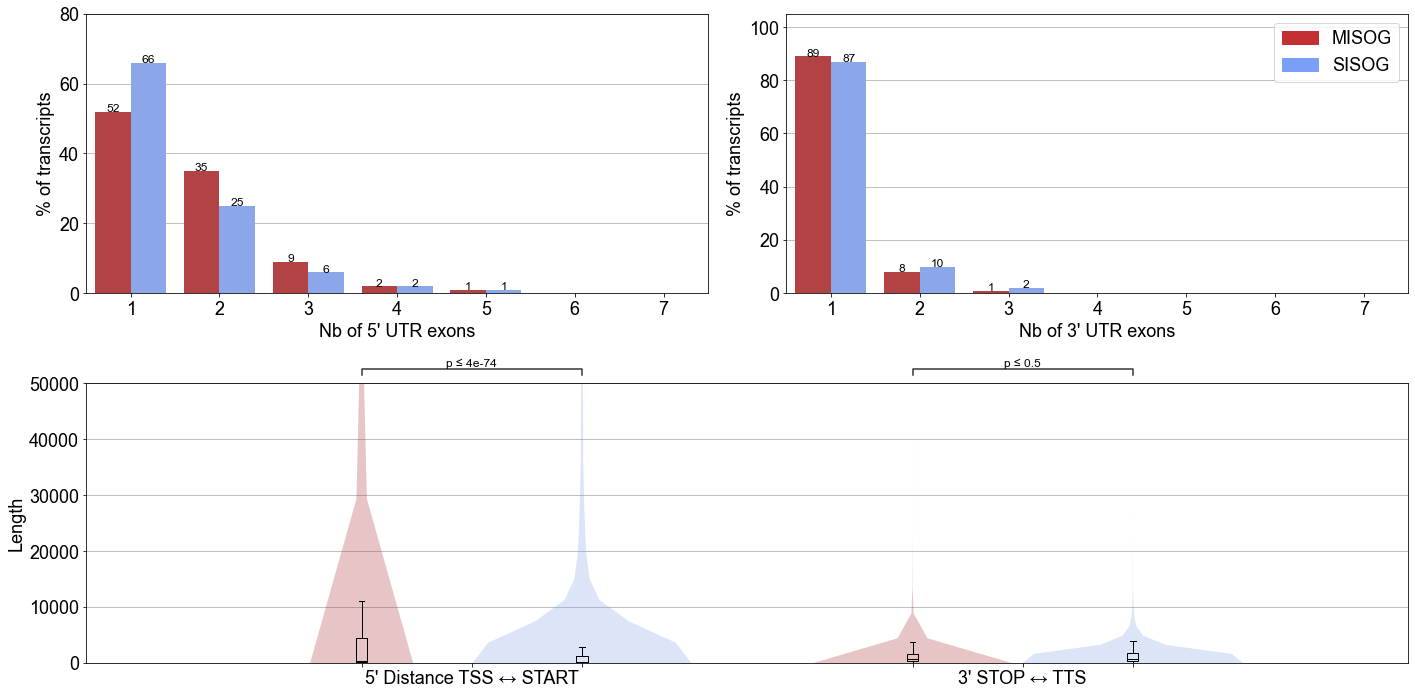

In [39]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            if np.isnan(p.get_height()) == False and p.get_height() > 0.4:
                value = '{:0}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center", fontsize=12) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
        
        
fig = plt.figure(figsize=(20, 10)) 
gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[1, 1]) 
ax00 = plt.subplot(gs[0,0])
ax01 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0:])



data_5_prime = 100 * ( five_UTR.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["5' UTR start"].count().reset_index().groupby('Miso_siso')["5' UTR start"].value_counts() / five_UTR.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["5' UTR start"].count().reset_index().groupby('Miso_siso')["5' UTR start"].value_counts().groupby('Miso_siso').sum())
data_5_prime = data_5_prime.rename('count').reset_index()
data_5_prime = data_5_prime.loc[data_5_prime["5' UTR start"] <= 7]
data_5_prime = data_5_prime.round()
data_3_prime = 100 * ( three_UTR.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["3' UTR start"].count().reset_index().groupby('Miso_siso')["3' UTR start"].value_counts() / three_UTR.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["3' UTR start"].count().reset_index().groupby('Miso_siso')["3' UTR start"].value_counts().groupby('Miso_siso').sum())
data_3_prime = data_3_prime.rename('count').reset_index()
data_3_prime = data_3_prime.loc[data_3_prime["3' UTR start"] <= 7]
data_3_prime = data_3_prime.round()


sns.barplot(data=data_5_prime, x="5' UTR start", y='count', hue='Miso_siso', palette=palette, ax=ax00)
sns.barplot(data=data_3_prime, x="3' UTR start", y='count', hue='Miso_siso', palette=palette, ax=ax01)


show_values_on_bars(ax00)
show_values_on_bars(ax01)


ax00.set_ylim(ymax=80)
ax01.set_ylim(ymax=105)
ax00.set_ylabel("% of transcripts")
ax00.set_xlabel("Nb of 5' UTR exons")
ax01.set_ylabel("% of transcripts")
ax01.set_xlabel("Nb of 3' UTR exons")
# ax00.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['M-iso', 'S-iso'])
ax01.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['MISOG', 'SISOG'])

ax00.legend().remove()

l_axes = [ax00, ax01, ax3]

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }


distance_tss_start_strand_positive = (cds.loc[cds['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_start_abs'].min() - exons.loc[exons['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region start (bp)'].min())
distance_tss_start_strand_negative = (exons.loc[exons['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region end (bp)'].max() - cds.loc[cds['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_end_abs'].max())
tss_start = pd.concat([distance_tss_start_strand_positive, distance_tss_start_strand_negative]).rename('Length').reset_index()
tss_start['Distance_START_STOP'] = 'START'

distance_tts_stop_strand_positive = (exons.loc[exons['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region end (bp)'].max() - cds.loc[cds['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_end_abs'].max())
distance_tts_stop_strand_negative = (cds.loc[cds['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_start_abs'].min() - exons.loc[exons['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region start (bp)'].min())
tts_stop = pd.concat([distance_tts_stop_strand_positive, distance_tts_stop_strand_negative]).rename('Length').reset_index()
tts_stop['Distance_START_STOP'] = 'STOP'

tss_tts_final_df = pd.concat([tss_start, tts_stop])

t = cds[['GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'CDS_start_abs', 'CDS_end_abs']].drop_duplicates().groupby('GeneID')['CDS_start_abs'].count()

tss_tts_final_df = tss_tts_final_df.loc[~tss_tts_final_df['GeneID'].isin(t[t == 1].index.tolist())]


data = tss_tts_final_df.rename({'Distance_START_STOP' : 'variable', 'Length' : 'value'}, axis=1)


bw = 0.25
cut = 0.05
lw = 0


x, y, hue = 'variable', 'value', 'Miso_siso'
print(data.groupby(['Miso_siso', 'variable'])['value'].describe())

box =sns.violinplot(data=data, x='variable', y='value', hue='Miso_siso', showfliers=True, palette=palette, ax=ax3, bw=bw, cut=cut, linewidth=lw)
plt.setp(box.collections, alpha=.3)



box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Miso') & (data['variable'] == 'START')]['value'], positions=[-0.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Siso') & (data['variable'] == 'START')]['value'], positions=[+0.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Miso') & (data['variable'] == 'STOP')]['value'], positions=[0.8], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Siso') & (data['variable'] == 'STOP')]['value'], positions=[1.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})

ax3.set_xticklabels(["5' Distance TSS ↔ START", "3' STOP ↔ TTS"])
ax3.set_ylabel('Length')
ax3.set_xlabel('')
ax3.legend().remove()
box_pairs = [
    (('START', 'Miso'), ('START', 'Siso')),
    (('STOP', 'Miso'), ('STOP', 'Siso')),
]
ax3.set_ylim(0,0.5e5)

add_stat_annotation(ax3, data=data, x='variable', y='value', hue='Miso_siso', box_pairs=box_pairs, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff, fontsize=12,)
# ax.text(-0.1, 1.15, string.ascii_uppercase[i], transform=ax3.transAxes, size=25, weight='bold')



for ax in l_axes:
    ax.grid(axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()

# figure_path = base_dir + yaml['Figures']['Fig2']
# fig.savefig(figure_path, dpi=600)


In [42]:
exons

,Ortho_specie,Miso_siso,GeneID,transcript_id,Strand,Chromosome/scaffold name,Exon region start (bp),Exon region end (bp),Ordinal_nb,Ordinal_nb_inverted,Length
0,Mus_Musculus,Miso,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630554,18630722,1,-20,168
1,Mus_Musculus,Miso,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630265,18630459,2,-19,194
2,Mus_Musculus,Miso,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18630055,18630114,3,-18,59
3,Mus_Musculus,Miso,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18629139,18629231,4,-17,92
4,Mus_Musculus,Miso,ENSMUSG00000000028,ENSMUST00000000028,-1,16,18627482,18627619,5,-16,137
...,...,...,...,...,...,...,...,...,...,...,...
349593,Mus_Musculus,Siso,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156316004,156316171,8,-5,167
349594,Mus_Musculus,Siso,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156315542,156315630,9,-4,88
349595,Mus_Musculus,Siso,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156315358,156315431,10,-3,73
349596,Mus_Musculus,Siso,ENSMUSG00002076083,ENSMUST00000105569,-1,4,156314962,156315143,11,-2,181


In [49]:
plt.rcParams.update({'font.size' : 18})

def custom_boxplot(data, x, y, hue, ax, ylim, title="Title",xlabel="",ylabel="", box_pairs=[()], palette=['grey'], id_string="A", padding_value_boxplot=1, padding_title=10, legend=False, x_legend=0):

    data = data.sort_values(by=hue,ascending=True)
    count = data.groupby([hue, x]).count()['GeneID'].reset_index().pivot(columns=[hue],values='GeneID',index=x).reset_index()
    count['Miso'] = count['Miso'].apply(lambda r: str(format(int(r), ',')))
    count['Siso'] = count['Siso'].apply(lambda r: str(format(int(r), ',')))
    count['Miso/Siso'] = count[x].astype(str) + '\n(' + count['Miso'] + ' / ' + count['Siso'] + ')'
    
    
    bw = 0.2
    cut = 0
    lw = 1.5

    box = sns.violinplot(data=data, x=x, y=y, hue=hue, showfliers=False, ax=ax, cut=cut, linewidth=lw, bw=bw, scale='width', alpha=0.3, palette=palette)

    plt.setp(box.collections, alpha=.3)

        
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Length (bp)')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xticklabels(count['Miso/Siso'].values.tolist(), fontsize=14)
    
    if not x: 
        ax.spines['bottom'].set_linewidth(0)
        ax.axes.xaxis.set_visible(False)
        
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    
    if legend is True:
    
        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles= 
                  [ 
                    mpatches.Patch([0], [0], color=palette['Miso'], ),
                    mpatches.Patch([0], [0], color=palette['Siso'], ),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
#                     matplotlib.lines.Line2D([0], [0], marker='s', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15)
                    ],  
              labels= ['MISOG', 'SISOG', "Median"], title='', ncol=3, bbox_to_anchor=(0.5,-1), loc='center right')
    else:
        ax.legend().remove()

    means = data.groupby([hue, x])[y].quantile(0.75).reset_index()
    medians = data.groupby([hue, x])[y].quantile(0.5).reset_index()
    for ms, x_shift in zip(['Miso', 'Siso'], [-0.2,0.2]):
        tmp_df_medians = medians.loc[medians['Miso_siso'] == ms]
        tmp_df_means = means.loc[means['Miso_siso'] == ms]
        x_plot = [e + x_shift for e in range(0,5)]
        if 'Introns' in title :
            ax.plot(x_plot, tmp_df_means[y].values, lw=2.5, color=palette[ms],  marker="s", markersize=8, markeredgecolor="black",  markeredgewidth=1, ls='-', )
            ax.plot(x_plot, tmp_df_medians[y].values, lw=2.5, color="white",  marker="o", markersize=6, markeredgecolor="black",  markeredgewidth=1, ls='', )
        else:
            ax.plot(x_plot, tmp_df_medians[y].values, lw=2.5, color=palette[ms],  marker="o", markersize=10, markeredgecolor="black",  markeredgewidth=1, ls='-', )

    add_stat_annotation(ax, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                        test='Mann-Whitney', text_format='simple',  pvalue_thresholds=pvalues_cutoff,
                        loc='outside', fontsize=9, verbose=2, line_height=0.0025, line_offset=0.012)

    return ax

[((1, 'Miso'), (1, 'Siso')), ((2, 'Miso'), (2, 'Siso')), ((3, 'Miso'), (3, 'Siso')), ((4, 'Miso'), (4, 'Siso')), ((5, 'Miso'), (5, 'Siso')), ((1, 'Miso'), (2, 'Miso')), ((1, 'Miso'), (3, 'Miso')), ((1, 'Miso'), (4, 'Miso')), ((1, 'Miso'), (5, 'Miso')), ((1, 'Siso'), (2, 'Siso')), ((1, 'Siso'), (3, 'Siso')), ((1, 'Siso'), (4, 'Siso')), ((1, 'Siso'), (5, 'Siso'))]
2_Miso v.s. 2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.261e-42 U_stat=6.240e+07
1_Miso v.s. 1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.637e-45 U_stat=6.361e+07
3_Miso v.s. 3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.301e-22 U_stat=5.532e+07
4_Miso v.s. 4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.636e-13 U_stat=4.726e+07
5_Miso v.s. 5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.694e-08 U_stat=3.857e+07
1_Miso v.s. 2_Miso: Mann-Whitney-Wilcoxon tes

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


-4_Miso v.s. -4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.191e+04
-5_Miso v.s. -5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.118e+03
-3_Miso v.s. -3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.928e+04
-2_Miso v.s. -2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.140e-16 U_stat=5.485e+05
-1_Miso v.s. -1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.519e+07
-2_Miso v.s. -1_Miso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=3.655e+06
-2_Siso v.s. -1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.931e-222 U_stat=4.370e+05
-3_Miso v.s. -1_Miso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.930e-222 U_stat=1.527e+06
-3_Siso v.s. -1_Siso: Mann-Whitney-Wil

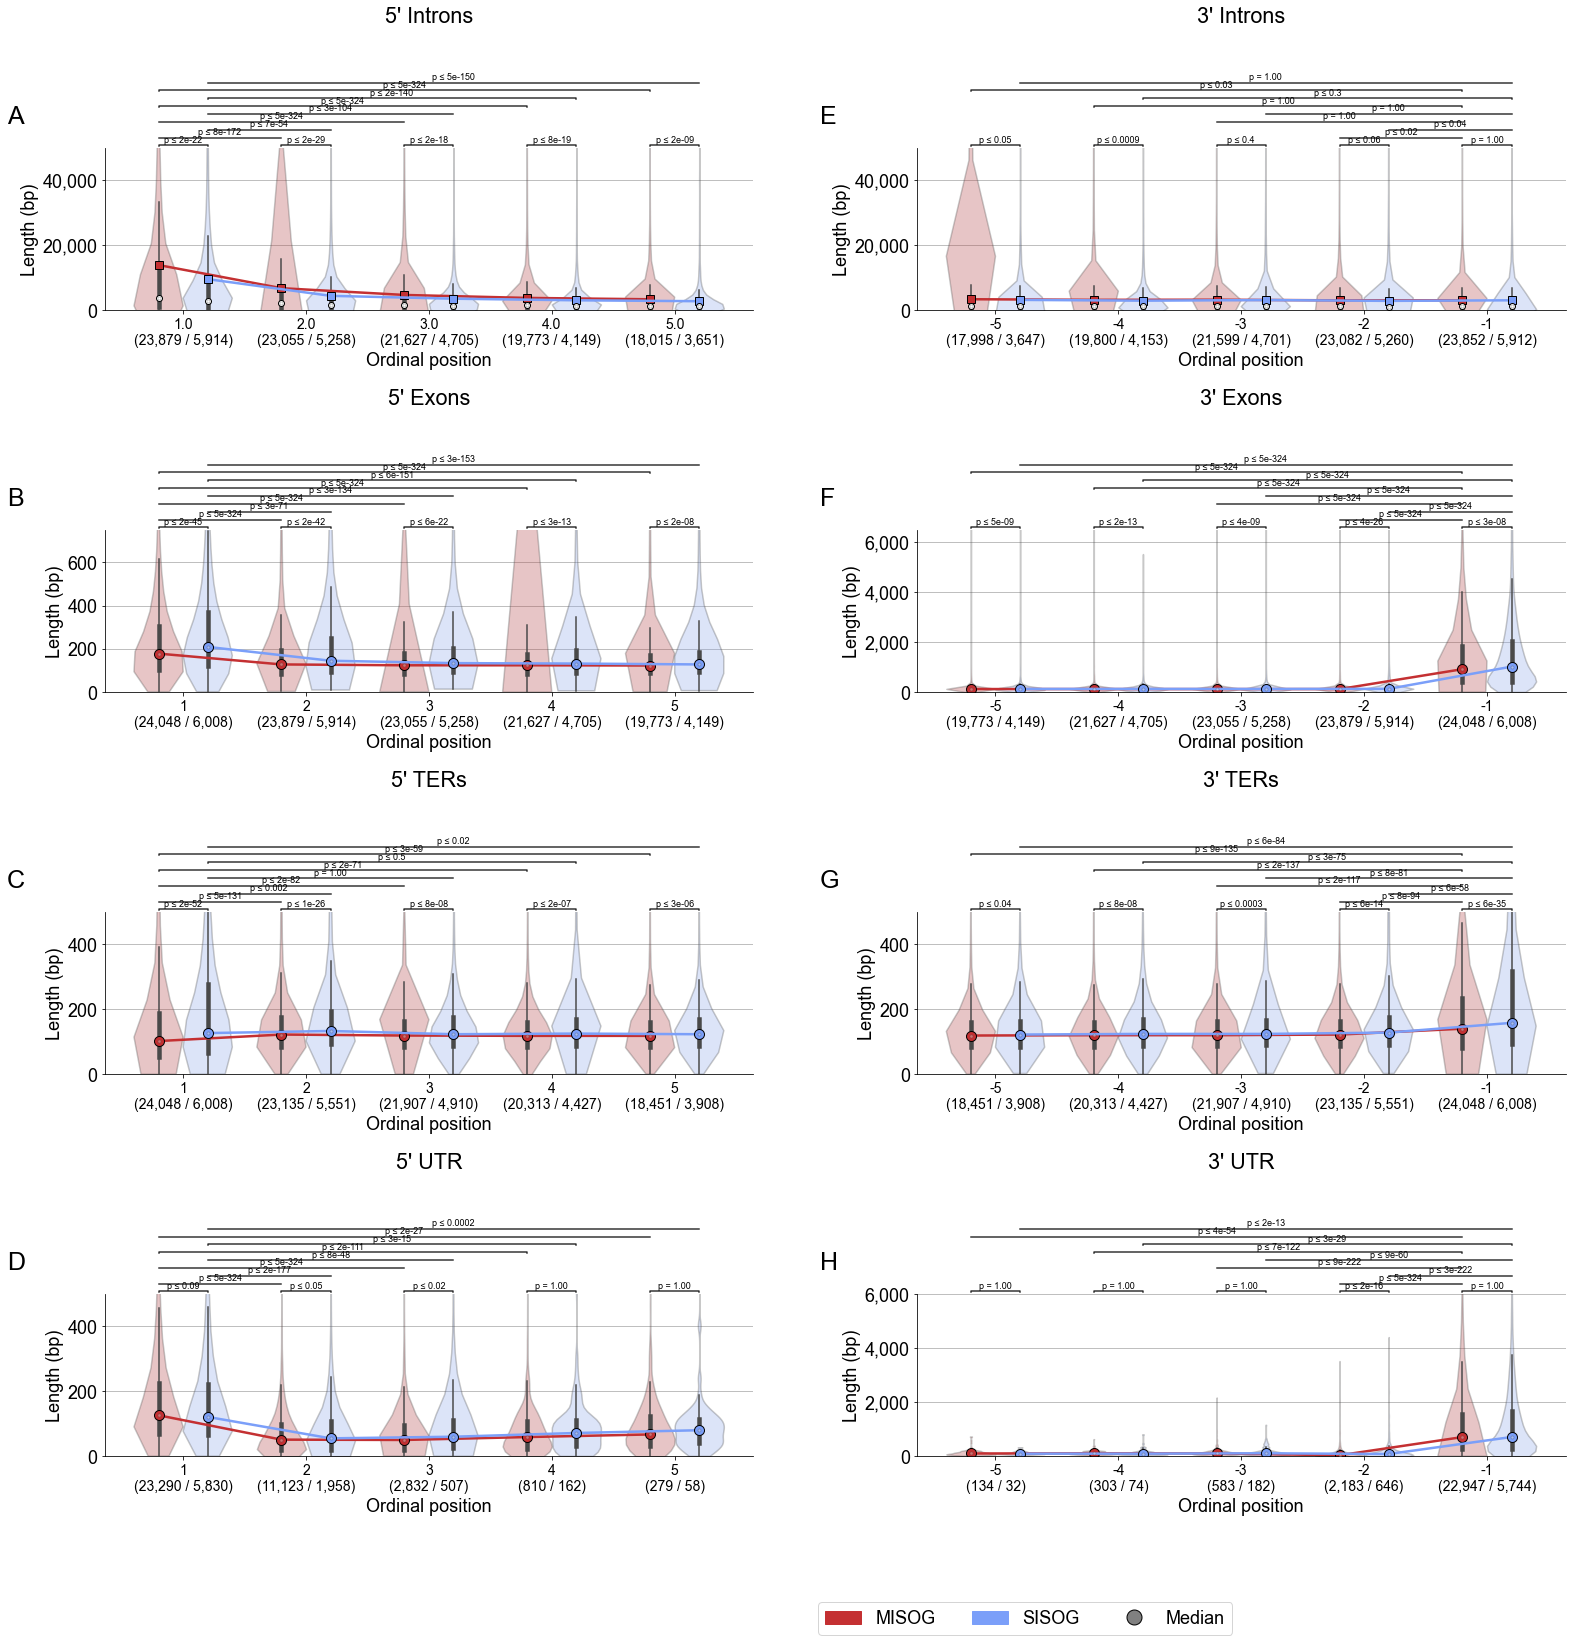

In [50]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(22,25))
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in range(1,6)
]

box_pairs = box_pairs + [((1,'Miso'),(e,'Miso')) for e in range(2,6)] + [((1,'Siso'),(e,'Siso')) for e in range(2,6)]

print(box_pairs)

k_limit = 5
zscore_cutoff = 2
padding_title = 125


custom_boxplot(data=exons.loc[(exons['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[1][0], ylim=(0,750), xlabel='Ordinal position', palette=palette, title="5' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=cds.loc[(cds['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', xlabel='Ordinal position', ax=ax[2][0], ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=introns.loc[(introns['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[0][0], xlabel='Ordinal position', ylim=(0,5e4), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' Introns", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=five_UTR.loc[(five_UTR['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[3][0], xlabel='Ordinal position', ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' UTR", box_pairs=box_pairs, padding_title=padding_title)


box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in list(range(-5,0))
]
box_pairs = box_pairs + [((-1,'Miso'),(e,'Miso')) for e in range(-5,-1)] + [((-1,'Siso'),(e,'Siso')) for e in range(-5,-1)]

custom_boxplot(data=exons.loc[(exons['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[1][1], ylim=(0,6.5e3), palette=palette, title="3' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=cds.loc[(cds['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso', xlabel='Ordinal position',ax=ax[2][1], ylim=(0,500), palette=palette, title="3' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=introns.loc[(introns['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[0][1], ylim=(0,50e3), palette=palette, title="3' Introns", box_pairs=box_pairs, padding_title=padding_title, )
custom_boxplot(data=three_UTR.loc[(three_UTR['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',  xlabel='Ordinal position',ax=ax[3][1], ylim=(0,6e3), palette=palette, title="3' UTR", box_pairs=box_pairs, padding_title=padding_title, legend=True, x_legend=1.35,)


i = 0
for n, a in enumerate(ax):
    print(a)
    sub_a = a[0]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1
for n, a in enumerate(ax):
    sub_a = a[1]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1

plt.tight_layout()

# figure_path = base_dir + yaml['Figures']['FigS1']
# f.savefig(figure_path, dpi=600)